# **Mercari Price Suggestion Challenge**

Kaggle: [Link](https://www.kaggle.com/c/mercari-price-suggestion-challenge)

Overview about the Challenge:
* Mercari is a Japanese organization that is an extension among Customers and Sellers. Mercari has difficulties choosing the correct cost for each item, to ensure both the purchaser and merchant are picked up from the deal.

* The Data Set consists of Numerical, Categorical and Text Data.

* The Metric used for this Challenge is RMSLE. 
    * RMSLE is very robust when outliers come into play
    * RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation


## Importing Libraries and Data 📚

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px #Plotly
import seaborn as sns
import re

from tqdm import tqdm
from matplotlib import pyplot as plt
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

print("Import Complete")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Import Complete


Points to Remember ✍️
*  Let us make a plunge by bringing in the data
*  The Train Data will be Utilized to Train the Model
*  The Test & Test Stage 2 both are Test data, without Price data

In [3]:
train = pd.read_csv("/content/drive/MyDrive/AAIC/CS-Merceri Price Challenge/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/AAIC/CS-Merceri Price Challenge/test.tsv", sep="\t")
test_stg2 = pd.read_csv("/content/drive/MyDrive/AAIC/CS-Merceri Price Challenge/test_stg2.tsv", sep="\t")

train = train.set_index('train_id')
test = test.set_index('test_id')
test_stg2 = test_stg2.set_index('test_id')

print("Train Shape:",train.shape)
print("Test Shape:", test.shape)
train.head(3)

Train Shape: (1482535, 7)
Test Shape: (693359, 6)


name  ...                                   item_description
train_id                                       ...                                                   
0         MLB Cincinnati Reds T Shirt Size XL  ...                                 No description yet
1            Razer BlackWidow Chroma Keyboard  ...  This keyboard is in great condition and works ...
2                              AVA-VIV Blouse  ...  Adorable top with a hint of lace and a key hol...

[3 rows x 7 columns]

## Checking for Nan Values
Points to Remember ✍️
* Let's Focus on the Nan Values or Missing data.
* Using MissingNo Library to understand the missing values using a Histogram and a Dendogram

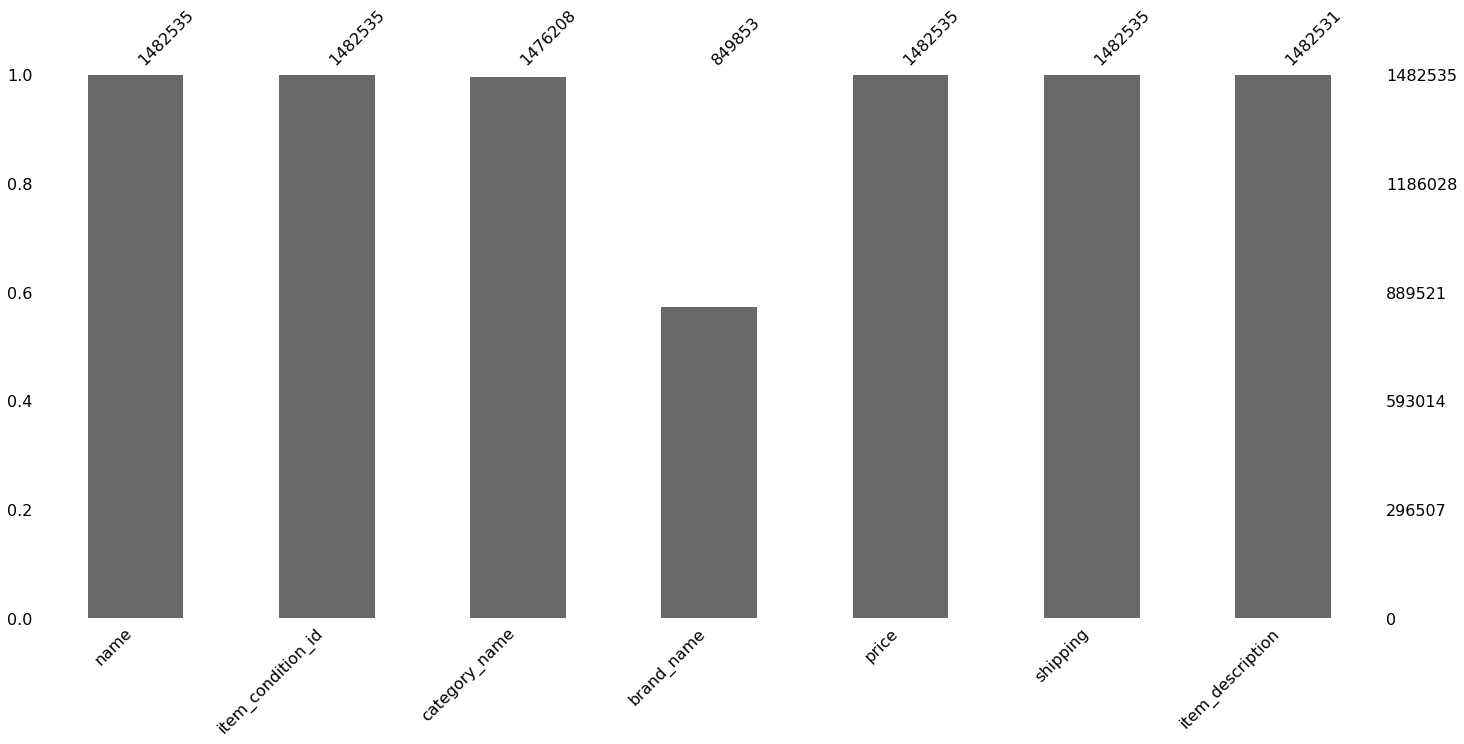

In [4]:
msno.bar(train)

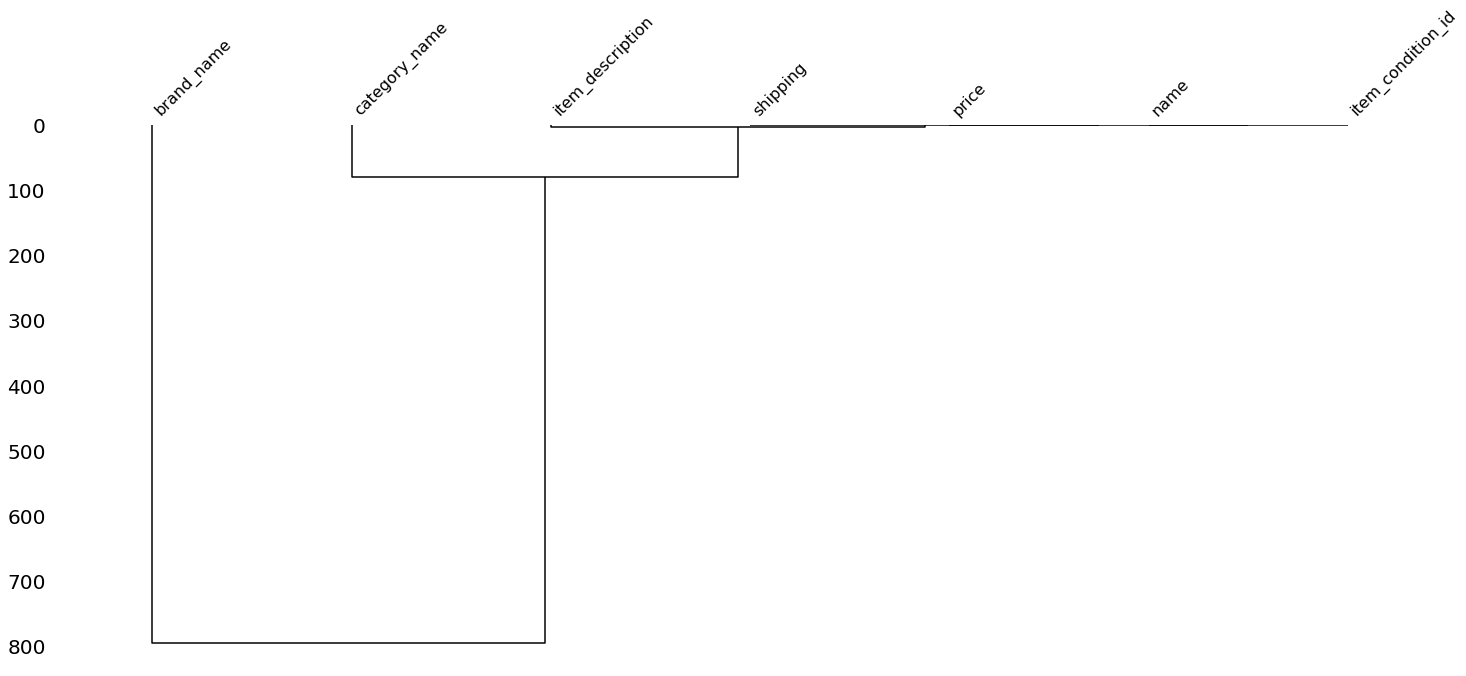

In [5]:
msno.dendrogram(train)

Points to Remember ✍️
* The histogram represents the Missing Data
    *  Almost 60% of the Brand Name are Missing. 
    *  Category Name, does have around 0.1% missing data, but it can be ignored
    *  The adove Dendogram represents Nullity Correlation between "**Brand**", "**Category Name**" and Others.
* Let us Analyze the Price Column

In [6]:
#train['brand_name'].fillna('no_brand', inplace=True)
print(train.price.describe(percentiles=[.10, .20, .30, .40, .50, .60, .70, .80, .90, .99]))
train['log_price'] = np.log10(train['price'])
train['log_price'] = train['log_price'].replace([np.inf, -np.inf], 0) #Replace with inf, -inf with 0

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
10%      7.000000e+00
20%      1.000000e+01
30%      1.200000e+01
40%      1.400000e+01
50%      1.700000e+01
60%      2.000000e+01
70%      2.600000e+01
80%      3.400000e+01
90%      5.100000e+01
99%      1.700000e+02
max      2.009000e+03
Name: price, dtype: float64


In [7]:
fig, axes = plt.subplots(figsize=(24, 7), sharey=True)
temp = train[train.price<200]       #Price Value
sns.distplot(temp.price, bins=25)

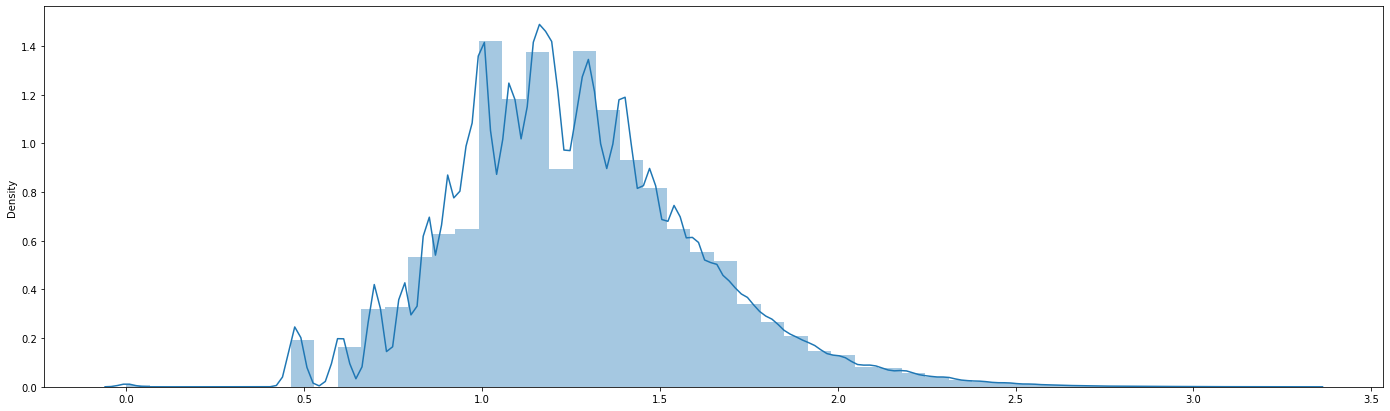

In [8]:
fig, axes = plt.subplots(figsize=(24, 7), sharey=True)
sns.distplot(ax=axes, x=train.log_price)

Points to Remember ✍️
*  Almost 99% of the data have price value in the range of (0,170) and only 1% of the data have price in the range of (170,2000)
*  Log can be applied to Price to lower the scale

## EDA & Data Preprocessing


Points to Remember ✍️
*  The Category Name consists of 3 Subclasses which can be further Divide.
*  Analysing the Category Allocation in the Data

In [9]:
def preprocessing_category(data):
    
    # Fill Na
    data['brand_name'].fillna('None', inplace=True)
    data['category_name'].fillna('None', inplace=True)
    data['item_description'].fillna('None', inplace=True)
    data['name'].fillna('None', inplace=True)

    # Splitting the Category
    main_category = []; category=[]; sub_category=[]

    for i in tqdm(data['category_name']):
        if i=='None':
            main_category.append('None') ; category.append('None'); sub_category.append('None')
        else:
            list1 = i.split("/")
            main_category.append(list1[0]) ; category.append(list1[1]); sub_category.append(list1[2])

    data['main_category'] = main_category ; data['category'] = category ; data['sub_category'] = sub_category # Creating 3 separate Columns

    return data

#Applying the Preprocessing Function to Data
train = preprocessing_category(train)

100%|██████████| 1482535/1482535 [00:01<00:00, 933969.19it/s]


#### Plotting for Category Vs Count

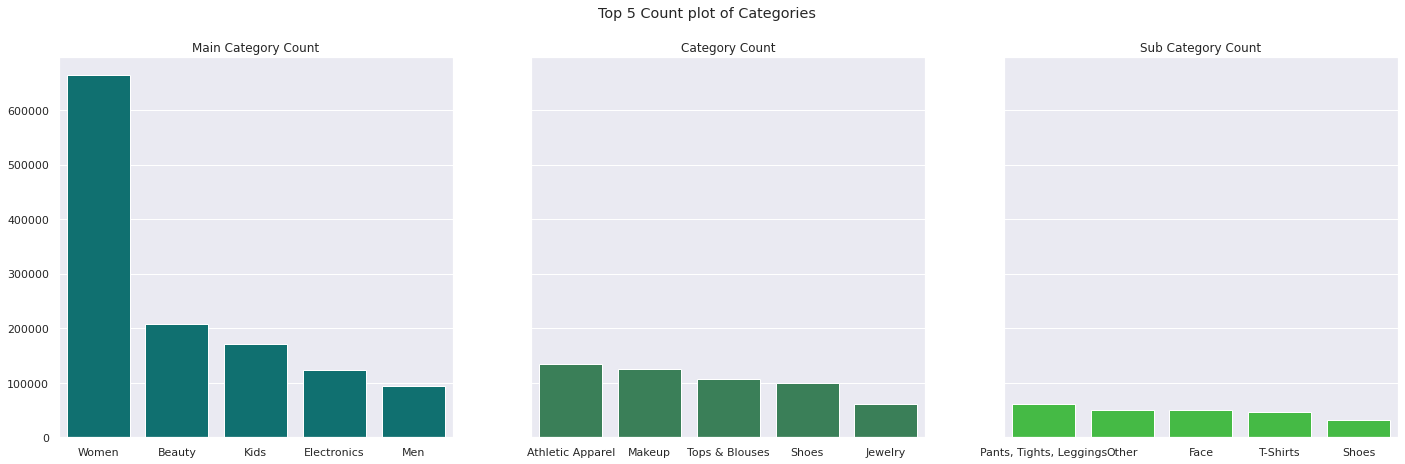

In [10]:
#Plotting for Category Vs Count
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
fig.suptitle('Top 5 Count plot of Categories')

# main_category
temp = train['main_category'].value_counts().head(5)
sns.barplot(ax=axes[0], x=list(temp.index.values), y=temp.values, color = 'teal')
axes[0].set_title("Main Category Count")

# category
temp = train['category'].value_counts().head(5)
sns.barplot(ax=axes[1], x=list(temp.index.values), y=temp.values, color= 'seagreen')
axes[1].set_title("Category Count")

# sub_category
temp = train['sub_category'].value_counts().head(5)
sns.barplot(ax=axes[2], x=list(temp.index.values), y=temp.values, color='limegreen')
axes[2].set_title("Sub Category Count");

In [11]:
fig, axes = plt.subplots(4, 1,figsize=(30, 24), sharey=True)

category_women = train[train['main_category']=="Women"]
sns.barplot(ax=axes[0], x=category_women.category, y=category_women.price, color= 'magenta')
axes[0].set_title("Price of SubCategory For Women")

category_men = train[train['main_category']=="Men"]
sns.barplot(ax=axes[1], x=category_men.category, y=category_men.price, color= 'cornflowerblue')
axes[1].set_title("Price of SubCategory For Men")

category_Electronics = train[train['main_category']=="Electronics"]
sns.barplot(ax=axes[2], x=category_Electronics.category, y=category_Electronics.price, color= 'darkturquoise')
axes[2].set_title("Price of SubCategory For Electronics")

category_kids = train[train['main_category']=="Kids"]
sns.barplot(ax=axes[3], x=category_kids.category, y=category_kids.price, color= 'wheat')
axes[3].set_title("Price of SubCategory For kids")

Text(0.5, 1.0, 'Price of SubCategory For kids')

Insights 💡
* Most of the products belong to Women Category
    * Women's Handbags are the Costly products in Women Category
* Shoes are the most costly products in Men Category
* Computers & Tablets are the most costly products in Electronics Category
* Pregnancy products are the most costly products in Kids Category

#### Most Sold Brand

In [12]:
fig, axes = plt.subplots(figsize=(20, 7), sharey=True)
temp = train['brand_name'].value_counts().head(10)
sns.barplot(ax=axes, x=temp.values, y=list(temp.index.values))

#### Most Costly brand and Average brand

Text(0.5, 1.0, 'Maximum Price of the Brands')

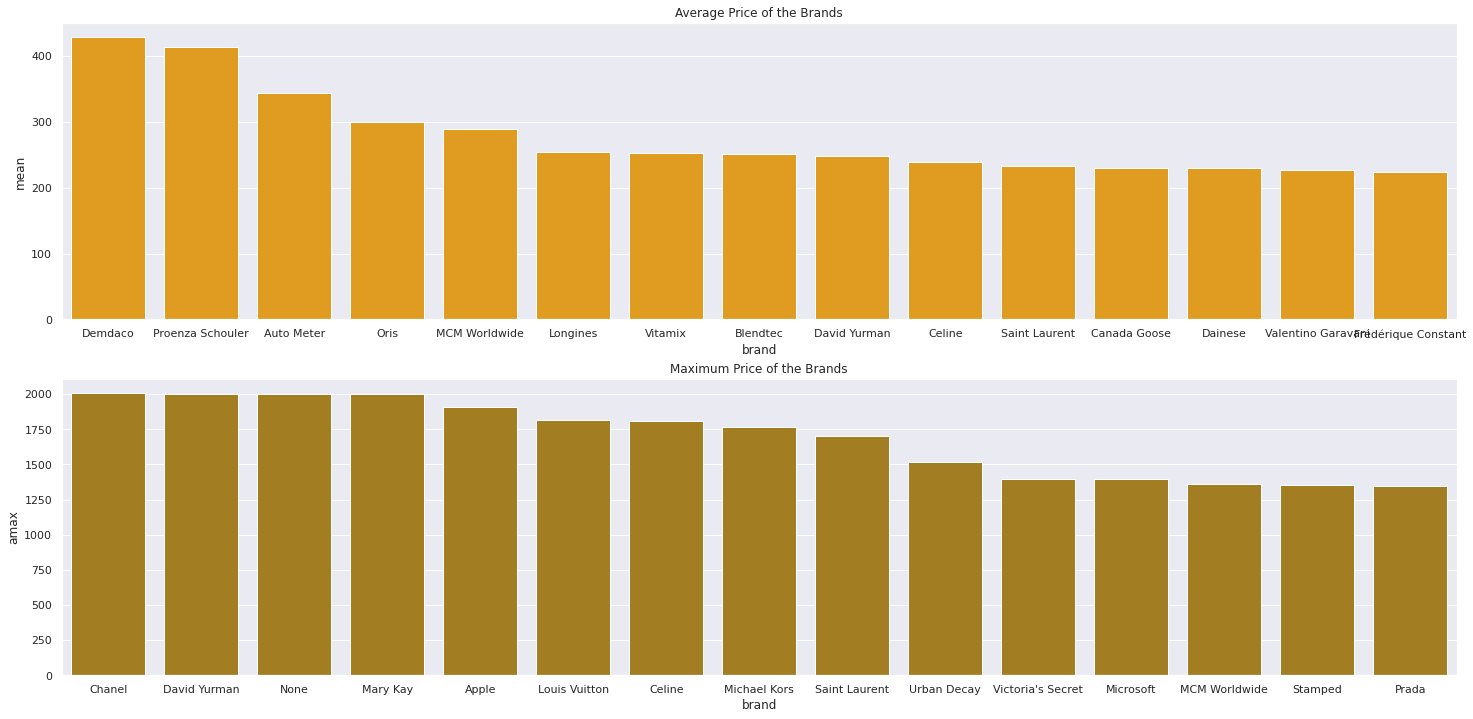

In [13]:
fig, axes = plt.subplots(2, 1,figsize=(25, 12))

group_by_brand = train.groupby("brand_name")
group_by_brand = group_by_brand['price'].agg([np.mean, np.max])
group_by_brand['brand'] = group_by_brand.index

# Top 15 Brands having the Average Values

mean_val_brand = group_by_brand.sort_values(by=['mean'], ascending=False)
mean_val_brand = mean_val_brand[0:15]

ax = sns.barplot(ax=axes[0], x="brand", y="mean", data=mean_val_brand, color="orange")
axes[0].set_title("Average Price of the Brands")

# Top 15 Brands having the Max Values
max_val_brand = group_by_brand.sort_values(by=['amax'], ascending=False)
max_val_brand = max_val_brand[0:15]

ax = sns.barplot(ax=axes[1], x="brand", y="amax", data=max_val_brand, color="darkgoldenrod")
axes[1].set_title("Maximum Price of the Brands")

#### Price Variation with Shipping

In [14]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.kdeplot(ax= axes, data=train, x="log_price", hue="shipping")

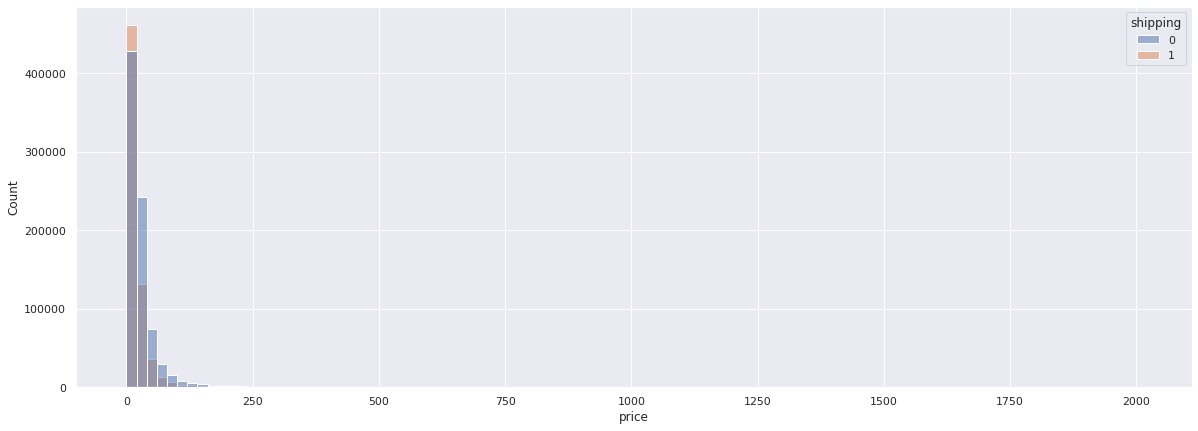

In [15]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.histplot(ax= axes, data=train, x="price", bins=100, hue="shipping")

#### item_condition_id relation with Price

In [16]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.boxplot(ax=axes, x="item_condition_id", y="log_price", data=train)

In [17]:
fig, axes = plt.subplots(figsize=(20, 7))
temp = train[train.price<180]
sns.violinplot(ax=axes,data=temp, x="item_condition_id", y="price", hue="shipping",split=True, inner="quart", linewidth=1)

#### Word Cloud

In [18]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.update(["stopword1", "stopword2"])

text = train['item_description'].values
wordcloud = WordCloud(width = 500,height = 300, background_color = 'white',stopwords=stopwords).generate(str(text))
fig = plt.figure(figsize = (10, 5),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [19]:
text = train['name'].values
wordcloud = WordCloud(width = 500,height = 300, background_color = 'white').generate(str(text))
fig = plt.figure(figsize = (10, 5),facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Points to Remember ✍️
*  Plot on Condition Vs Price, on Average Better the Condition, Higher the Price.

*  Most of the products sold fall under Women Category.
    *  Shoes are the Costly Items in Men Category
    *  Handbags are the Costly Items in Women Category
    *  Laptops are the Costly Items in Electronics Category
    *  Pregnancy Products are the Costly Items in Kids Category

*  Most Sold brands are: Pink, Nike & Victoria's Secret
    * Chanel & David Yurman are the Most Costly Brands 